In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(anndata))
library(ggplot2)
library(pheatmap)
library(RColorBrewer)
library(GenomicRanges)
source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT/BICAN_help.R")

### this is just to resize jupyter notebook plot size
library(repr)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following object i

In [2]:
lmeta <- read.csv("../04.clustering/02.RNA/03.l3_clustering/MiniAtlas_RNA_merged_dual_filt_clean_corrected_250722_metadata.txt", 
                  sep = "\t", row.names = 1)

In [3]:
### Add brain region color
cols <- read.csv("../../ref/yel_Science2023_supp/brain_dissection_anno.xls", sep = "\t")
col1 <- cols %>% dplyr::select(Brain.structure.name, Brain.structure.color) %>% distinct %>% dplyr::select(Brain.structure.color) %>% unlist
names(col1) <- cols %>% dplyr::select(Brain.structure.name, Brain.structure.color) %>% distinct %>% dplyr::select(Brain.structure.name) %>% unlist

col2 <- cols %>% dplyr::select(Brain.region, Brain.region.color) %>% distinct %>% dplyr::select(Brain.region.color) %>% unlist
names(col2) <- cols %>% dplyr::select(Brain.region, Brain.region.color) %>% distinct %>% dplyr::select(Brain.region) %>% unlist

In [4]:
cols <- read.csv("../../ref/yel_Science2023_supp/subclass_celltype_match.csv")
tmp <- distinct(cols[,c("Cell.class", "Cell.class.color")])
ccol1 <- tmp$Cell.class.color
names(ccol1) <- gsub("GLUT", "Glut", tmp$Cell.class)

tmp <- read.csv("../04.clustering/subclass_corrected.color.csv", row.names = 1)
ccol2 <- tmp$color
names(ccol2) <- tmp$MiniAtlas

In [5]:
bcol <- read.csv("../Figure/superterm.color", row.names = 1, sep = "\t")
ccol3 <- bcol$bcol
names(ccol3) <- rownames(bcol)

dcol <- c("#8ecae6", "#00acdf", "#006699")
names(dcol) <- unique(lmeta$donor)

tcol <- c("#2EA7E0", "#956134")
names(tcol) <- c("H3K27ac", "H3K27me3")

In [6]:
corder <- read.table("../04.clustering/order.subclass.250601", sep = "\t") %>% dplyr::select(V1) %>% unlist %>% as.character
corder2 <- read.table("../04.clustering/order.cluster.250601", sep = "\t") %>% dplyr::select(V1) %>% unlist %>% as.character

## Find matched human and mouse gene names

In [119]:
library(orthogene)
method <- "homologene"  

hgene <- read.table("/projects//ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/Paired-Tag/hg38/hg38.v43.10X.bed")
gene_df <- orthogene::convert_orthologs(gene_df = hgene,
                                        gene_input = "V6", 
                                        gene_output = "col", 
                                        input_species = "human",
                                        output_species = "mouse",
                                        non121_strategy = "drop_both_species",
                                        method = method) 

Preparing gene_df.

data.frame format detected.

Extracting genes from V6.

38,369 genes extracted.

Converting human ==> mouse orthologs using: homologene

Retrieving all organisms available in homologene.

Mapping species name: human

Common name mapping found for human

1 organism identified from search: 9606

Retrieving all organisms available in homologene.

Mapping species name: mouse

Common name mapping found for mouse

1 organism identified from search: 10090

Checking for genes without orthologs in mouse.

Extracting genes from input_gene.

16,224 genes extracted.

Extracting genes from ortholog_gene.

16,224 genes extracted.

Checking for genes without 1:1 orthologs.

Dropping 460 genes that have multiple input_gene per ortholog_gene (many:1).

Dropping 98 genes that have multiple ortholog_gene per input_gene (1:many).

Filtering gene_df with gene_map

Adding input_gene col to gene_df.

Adding ortholog_gene col to gene_df.


=========== REPORT SUMMARY ===========


Total gen

In [120]:
head(gene_df, 2)
nrow(gene_df)

,input_gene,ortholog_gene
,<chr>,<chr>
1,SAMD11,Samd11
2,NOC2L,Noc2l


[1] 15458

In [711]:
write.table(VariableFeatures(human), "../04.clustering/02.RNA/MiniAtlas_RNA_merged_dual_filt_clean_corrected_250529.var.feature", 
            sep = "\t", quote = F, row.names = F, col.names = F)

In [14]:
# https://www.nature.com/articles/s41594-023-01060-1
mouse <- readRDS("/projects//ps-renlab2/y2xie/ps-renlab/y2xie/projects/scifi-multiome/28.FC_16k_Droplet_PT_221210/05.R/seurat_object/FC_RNA_Seurat_merged_rmScrublet_221229.rds")

## Remove bad celltypes from mouse:
ctr <- c("STRGA", "OBGL", "OBGA")
mouse <- subset(mouse, subset = !(Anno0.8_yel %in% ctr))

mouse
intersect(rownames(mouse), gene_df$ortholog_gene) %>% length

An object of class Seurat 
32285 features across 20112 samples within 1 assay 
Active assay: RNA (32285 features, 2500 variable features)
 3 layers present: counts, data, scale.data
 3 dimensional reductions calculated: pca, harmony, umap

[1] 15282

Warning message:
“Removed 329 rows containing missing values or values outside the scale range (`geom_point()`).”


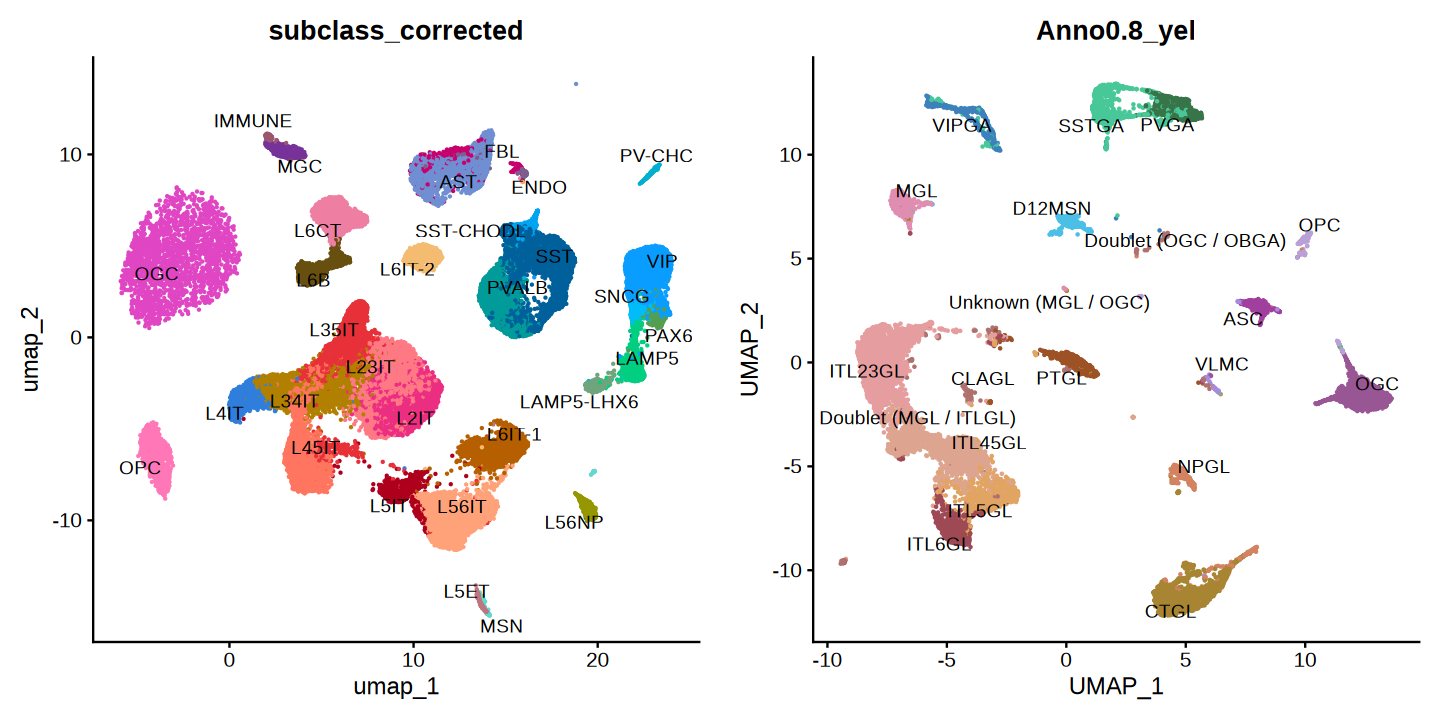

In [15]:
tmp <- mouse@meta.data[,c("Anno0.8_yel", "Subclass.color")] %>% distinct
ccol4 <- tmp$Subclass.color
names(ccol4) <- tmp$Anno0.8_yel

t1 <- DimPlot(human, group.by = "subclass_corrected", label = T, repel = T, cols = ccol2) + NoLegend()
t2 <- DimPlot(mouse, group.by = "Anno0.8_yel", label = T, repel = T, cols = ccol4) + NoLegend()

options(repr.plot.width = 12, repr.plot.height = 6)
cowplot::plot_grid(t1, t2)

## Integrate with CCA

In [470]:
sgene <- intersect(which(gene_df$input_gene %in% rownames(human)), which(gene_df$ortholog_gene %in% rownames(mouse)))
length(sgene)

[1] 15288

In [581]:
### remove bad cells (final)
qcell <- rownames(mouse@meta.data[mouse$RNA_keep_cells == 'True',])
qgenedf <- gene_df[sgene,] %>% distinct
qmtx <- mouse[["RNA"]]@counts[unique(qgenedf[, 2]), qcell]
rownames(qmtx) <- unique(qgenedf[, 1])

tmp1 <- CreateSeuratObject(counts = human[["RNA"]]$counts[unique(qgenedf[, 1]),], meta.data = human@meta.data)
tmp2 <- CreateSeuratObject(counts = qmtx, meta.data = mouse@meta.data[qcell,])

obj <- merge(tmp1, tmp2)

In [582]:
translate <- read.table("/projects/ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/arc_bc-translation.txt", header = T, row.names = 1, sep = "\t")
translate$atac <- paste0(translate$atac, "-1")
translate$rna <- paste0(translate$rna, "-1")
obj$rna_bc <- stringr::str_split_fixed(colnames(obj), pattern = ":", n = 2)[,2]
obj$atac_bc <- translate[match(obj$rna_bc, translate$rna),]$atac

In [583]:
### Default CCA integration
obj <- NormalizeData(obj)
obj <- FindVariableFeatures(obj, nfeatures = 3000)
obj <- ScaleData(obj)
obj <- RunPCA(obj, verbose = F)

obj <- IntegrateLayers(
    object = obj, method = CCAIntegration,
    orig.reduction = "pca", new.reduction = "integrated.cca",
    verbose = FALSE
)

obj <- RunUMAP(obj, seed.use = 131, reduction = "integrated.cca", dims = 1:35, reduction.name = "umap.cca",
               min.dist = 0.1, n.components = 2L, umap.method = "umap-learn", verbose = F)

Normalizing layer: counts.1

Normalizing layer: counts.2

Finding variable features for layer counts.1

Finding variable features for layer counts.2

Centering and scaling data matrix



In [584]:
obj <- FindNeighbors(obj, reduction = "integrated.cca", dims = 1:35, verbose = F)
obj <- FindClusters(obj, resolution = 0.7, verbose = F)

Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


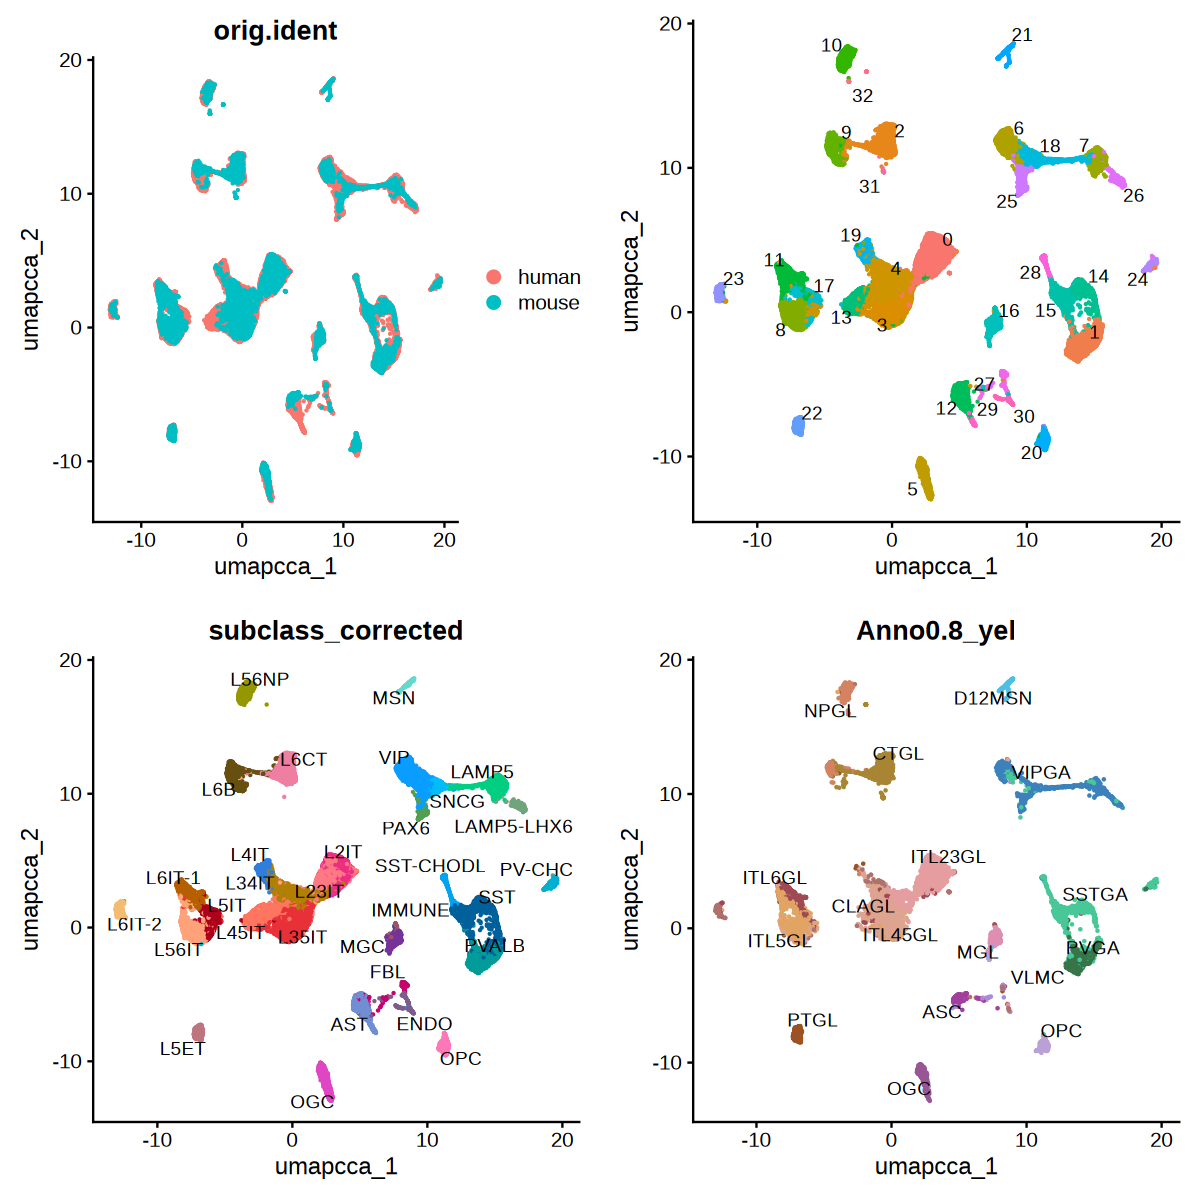

In [585]:
obj@meta.data[is.na(obj$subclass_corrected),]$orig.ident <- "mouse"
obj@meta.data[!is.na(obj$subclass_corrected),]$orig.ident <- "human"

t0 <- DimPlot(obj, group.by = "orig.ident", label = F, repel = T)
t1 <- DimPlot(obj, group.by = "subclass_corrected", label = T, repel = T, cols = ccol2, 
              cells = rownames(obj@meta.data[obj$orig.ident == "human", ])) + NoLegend()
t2 <- DimPlot(obj, group.by = "Anno0.8_yel", label = T, repel = T, cols = ccol4,
              cells = rownames(obj@meta.data[obj$orig.ident == "mouse", ])) + NoLegend()
t3 <- DimPlot(obj, label = T, repel = T) + NoLegend()

options(repr.plot.width = 10, repr.plot.height = 10)
cowplot::plot_grid(t0, t3, t1, t2, ncol = 2)

In [64]:
obj$dna_bc <- NA
obj@meta.data[obj$orig.ident == "human",]$dna_bc <- paste0(obj@meta.data[obj$orig.ident == "human",]$dna, ":", obj@meta.data[obj$orig.ident == "human",]$atac_bc)
obj@meta.data[obj$orig.ident == "mouse",]$dna_bc <- paste0(gsub("([^_]+)_([^_]+)", "\\1", obj@meta.data[obj$orig.ident == "mouse",]$arc), ":", obj@meta.data[obj$orig.ident == "mouse",]$atac_bc)

Using ovlpScore as value column: use value.var to override.



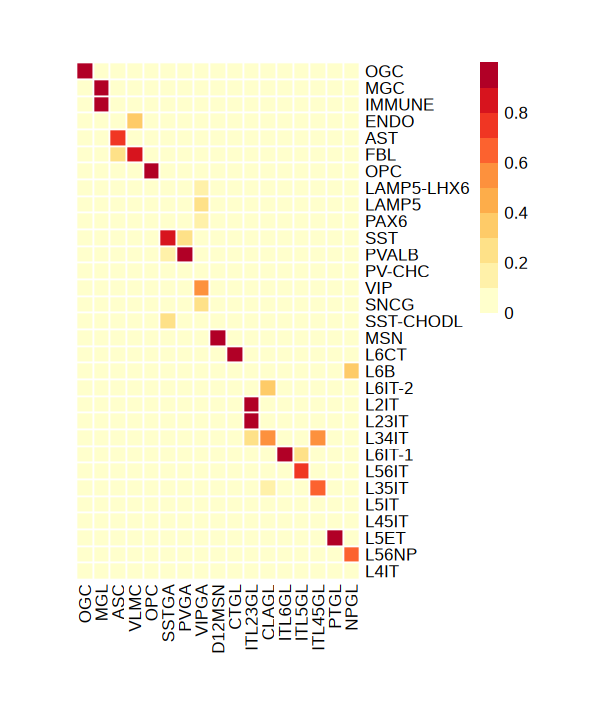

In [619]:
t1 <- obj@meta.data[obj$orig.ident == "human", c("seurat_clusters", "subclass_corrected")]
t2 <- obj@meta.data[obj$orig.ident == "mouse", c("seurat_clusters", "Anno0.8_yel")]
ovlp_score <- cal_ovlpScore(t1, t2)

rmat <- ovlp_score %>%
reshape2::dcast(anno1 ~ anno2) %>%
tibble::column_to_rownames("anno1") %>% t

ctk <- which(apply(rmat, 1, max) > 0.01)
rmat <- rmat[ctk, intersect(corder, colnames(rmat))]

max_indices <- max.col(rmat)
permutation_vector <- order(max_indices)
smat <- rmat[permutation_vector, ] %>% t

options(repr.plot.width = 5, repr.plot.height = 6)
p1 <- smat %>% 
pheatmap(cluster_rows = F, cluster_cols = F, border_color = "white", angle_col = 90, 
         cellheight = 10, cellwidth = 10,
         color = colorRampPalette(brewer.pal(n = 8, name = "YlOrRd"))(10))

In [587]:
obj$slabel <- NA
obj@meta.data[obj$orig.ident == "human", ]$slabel <- obj@meta.data[obj$orig.ident == "human", ]$subclass_corrected
obj@meta.data[obj$orig.ident == "mouse", ]$slabel <- obj@meta.data[obj$orig.ident == "mouse", ]$Anno0.8_yel

## Reannotate mouse celltype based on human results to find common cell types

In [590]:
qcluster <- table(obj$subclass_corrected, obj$seurat_clusters) %>% colnames
d1 <- table(obj$subclass_corrected, obj$seurat_clusters) %>%
apply(MARGIN = 1, function(x) qcluster[which(x == max(x))]) %>%
as.data.frame %>% setNames("louvain") %>%
arrange(as.integer(louvain)) %>% tibble::rownames_to_column("hcelltype")

qcluster <- table(obj$Anno0.8_yel, obj$seurat_clusters) %>% colnames
d2 <- table(obj$Anno0.8_yel, obj$seurat_clusters) %>%
apply(MARGIN = 1, function(x) qcluster[which(x == max(x))]) %>%
as.data.frame %>% setNames("louvain") %>%
arrange(as.integer(louvain)) %>% tibble::rownames_to_column("mcelltype")

dm <- merge(d1, d2, by = "louvain", all = T)

In [11]:
obj$snlabel <- NA
obj@meta.data[obj$seurat_clusters == 0, ]$snlabel <- "share_L23IT"
obj@meta.data[obj$seurat_clusters == 1, ]$snlabel <- "share_PVALB"
obj@meta.data[obj$seurat_clusters == 2, ]$snlabel <- "share_CT" 
obj@meta.data[obj$seurat_clusters == 3, ]$snlabel <- "share_L35IT"
obj@meta.data[obj$seurat_clusters == 4, ]$snlabel <- "share_L34IT"
obj@meta.data[obj$seurat_clusters == 5, ]$snlabel <- "share_OGC"
obj@meta.data[obj$seurat_clusters == 6, ]$snlabel <- "share_VIP"
obj@meta.data[obj$seurat_clusters == 7, ]$snlabel <- "share_LAMP5"
obj@meta.data[obj$seurat_clusters == 8, ]$snlabel <- "share_L56IT"
obj@meta.data[obj$seurat_clusters == 9, ]$snlabel <- "share_L6B"
obj@meta.data[obj$seurat_clusters == 10, ]$snlabel <- "share_NP"
obj@meta.data[obj$seurat_clusters == 11, ]$snlabel <- "share_L6IT-1"
obj@meta.data[obj$seurat_clusters == 12, ]$snlabel <- "share_AST"
obj@meta.data[obj$seurat_clusters == 13, ]$snlabel <- "share_L45IT"
obj@meta.data[obj$seurat_clusters == 14, ]$snlabel <- "share_SST"
obj@meta.data[obj$seurat_clusters == 15, ]$snlabel <- "share_SST"
obj@meta.data[obj$seurat_clusters == 16, ]$snlabel <- "share_MGC"
obj@meta.data[obj$seurat_clusters == 17, ]$snlabel <- "share_L5IT"
obj@meta.data[obj$seurat_clusters == 18, ]$snlabel <- "share_SNCG"
obj@meta.data[obj$seurat_clusters == 19, ]$snlabel <- "share_L4IT_vis"
obj@meta.data[obj$seurat_clusters == 20, ]$snlabel <- "share_OPC"
obj@meta.data[obj$seurat_clusters == 21, ]$snlabel <- "share_MSN"
obj@meta.data[obj$seurat_clusters == 22, ]$snlabel <- "share_PT"
obj@meta.data[obj$seurat_clusters == 23, ]$snlabel <- "share_L6IT-2"
obj@meta.data[obj$seurat_clusters == 24, ]$snlabel <- "share_PV-CHC"
obj@meta.data[obj$seurat_clusters == 25, ]$snlabel <- "share_PAX6"
obj@meta.data[obj$seurat_clusters == 26, ]$snlabel <- "share_LAMP5-LHX6"
obj@meta.data[obj$seurat_clusters == 27, ]$snlabel <- "share_FBL"
obj@meta.data[obj$seurat_clusters == 28, ]$snlabel <- "share_SST-CHODL"
obj@meta.data[obj$seurat_clusters == 29, ]$snlabel <- "share_AST"
obj@meta.data[obj$seurat_clusters == 30, ]$snlabel <- "share_ENDO"
obj@meta.data[obj$seurat_clusters == 31, ]$snlabel <- "share_CT"
obj@meta.data[obj$seurat_clusters == 32, ]$snlabel <- "share_NP"

In [14]:
tcorder <- c('share_OGC', 'share_MGC', 'share_ENDO', 'share_AST', 'share_FBL', 'share_OPC', 'share_LAMP5-LHX6', 'share_LAMP5', 'share_PAX6', 'share_SST', 'share_PVALB', 'share_PV-CHC', 'share_VIP', 'share_SNCG', 'share_SST-CHODL', 'share_MSN', 'share_CT', 'share_L6B', 'share_L6IT-2', 'share_L23IT', 'share_L34IT', 'share_L6IT-1', 'share_L56IT', 'share_L35IT', 'share_L5IT', 'share_L45IT', 'share_PT', 'share_NP', 'share_L4IT_vis')

In [15]:
ccol5 <- c('#e045c3', '#773299', '#7d5d8b', '#6f8fd2', '#c7006e', '#ff77b7', '#70a47c', '#00ce80', '#539e51', '#00609b', '#019c99', '#03afcf', '#099dff', '#00bcfa', '#01a4f1', '#7fbb7a', '#ee7ea2', '#674f10', '#f4bc71', '#ff7985', '#b18000', '#b65f00', '#ffa179', '#e83038', '#ae001d', '#ff7560', '#bd7580', '#959700', '#307edc')
names(ccol5) <- tcorder

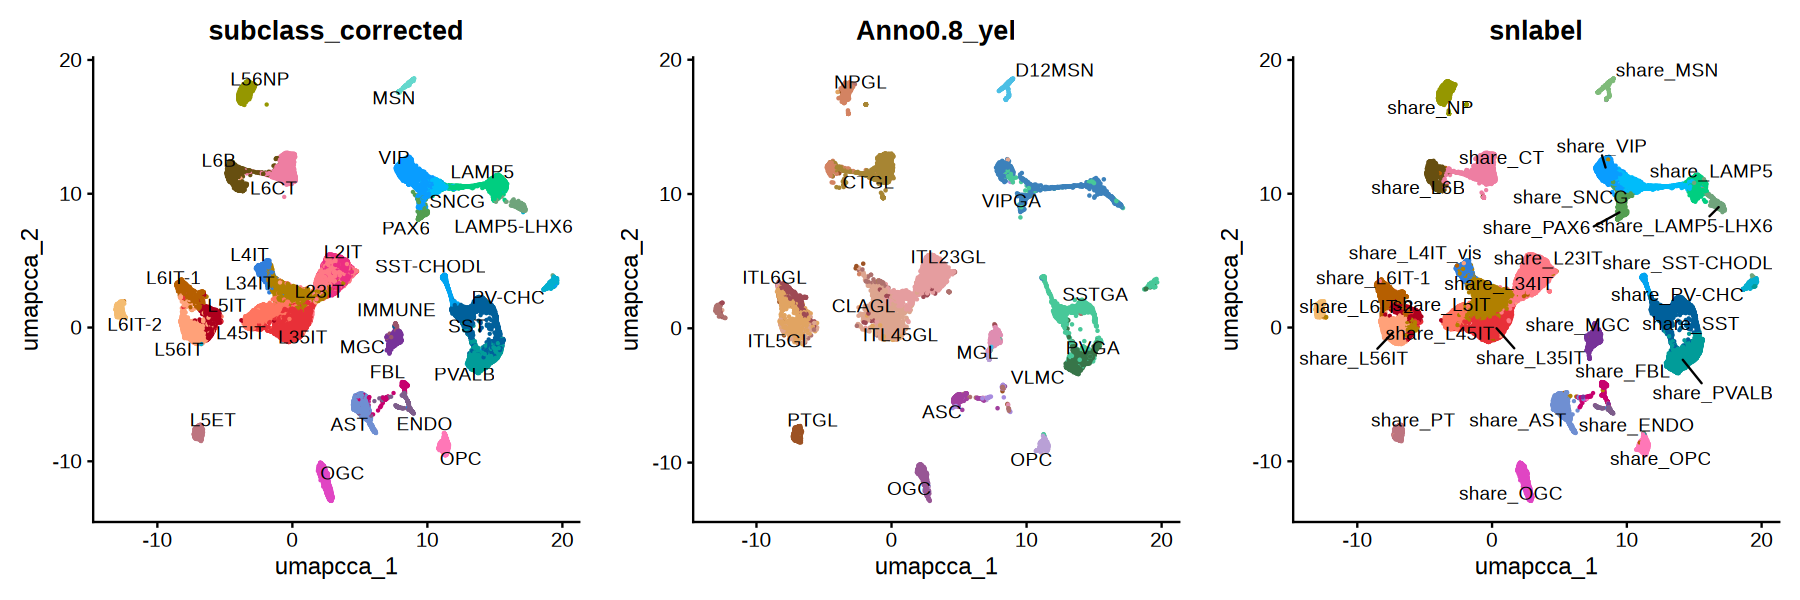

In [44]:
t1 <- DimPlot(obj, group.by = "subclass_corrected", label = T, repel = T, cols = ccol2, 
              cells = rownames(obj@meta.data[obj$orig.ident == "human", ])) + NoLegend()
t2 <- DimPlot(obj, group.by = "Anno0.8_yel", label = T, repel = T, cols = ccol4,
              cells = rownames(obj@meta.data[obj$orig.ident == "mouse", ])) + NoLegend()
t3 <- DimPlot(obj, group.by = "snlabel", label = T, repel = T, cols = ccol5) + NoLegend()

options(repr.plot.width = 15, repr.plot.height = 5)
cowplot::plot_grid(t1, t2, t3, ncol = 3)

In [1111]:
table(obj$orig.ident)


human mouse 
65535 19783 

## Compare regulatory program activity

In [185]:
### chromvar using gpu chromvar: https://ruochiz.com/scprinter_doc/tutorials/gpu_chromvar.html
library(anndata)
hvar <- read_h5ad("../07.cCREs/MiniAtlas_H3K27ac_snATAC_whole.union.peaks_250601.sample.chromvar.h5ad")
mvar <- read_h5ad("mouse_process/snapatac2/Mouse_FC_H3K27ac_CEMBA_cCREs_251024.chromvar.h5ad")
hvar
mvar

AnnData object with n_obs × n_vars = 35296 × 1956
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score_x', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.ribo', 'doublet_score_y', 'doublet_ident', 'dna', 'rna', 'region', 'structure', 'donor', 'target', 'rna_bc', 'atac_bc', 'index', 'condition', 'leiden', 'subclass', 'subclass_corrected', 'supercluster_manual', 'cluster_manual_name', 'class'

AnnData object with n_obs × n_vars = 11369 × 1956
    obs: 'sample_x', 'leiden', 'orig.ident', 'nCount_DNA', 'nFeature_DNA', 'sample_y', 'DNA_snn_res.0.5', 'seurat_clusters', 'nCount_GA', 'nFeature_GA', 'arc', 'bc', 'rna_bc', 'rna_cluster', 'rna_Anno0.8_yel', 'dna_Anno0.8_transfer', 'DNA_keep_cells', 'RNA_keep_cells', 'predicted.id.score', 'predicted.id', 'rna_Anno0.8', 'int_umap_2', 'int_umap_1', 'Class', 'Class.color', 'Subclass.color'

In [233]:
hvarseurat <- CreateAssayObject(data = t(hvar$X))
hvarseurat <- CreateSeuratObject(hvarseurat, meta.data = hvar$obs)
hvarseurat[["RNA"]]$scale.data <- hvarseurat[["RNA"]]$data

mvarseurat <- CreateAssayObject(data = t(mvar$X))
mvarseurat <- CreateSeuratObject(mvarseurat, meta.data = mvar$obs)
mvarseurat[["RNA"]]$scale.data <- mvarseurat[["RNA"]]$data

saveRDS(hvarseurat, "../07.cCREs/MiniAtlas_H3K27ac_snATAC_whole.union.peaks_250601.sample.chromvar.rds")
saveRDS(mvarseurat, "mouse_process/snapatac2/Mouse_FC_H3K27ac_CEMBA_cCREs_251024.chromvar.rds")

In [1118]:
hvar2 <- read_h5ad("../07.cCREs/MiniAtlas_H3K27me3_snATAC_whole.union.peaks_250601.sample.chromvar.h5ad")
mvar2 <- read_h5ad("mouse_process/snapatac2/Mouse_FC_H3K27me3_CEMBA_cCREs_251024.chromvar.h5ad")
hvar2
mvar2

AnnData object with n_obs × n_vars = 35239 × 1956
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score_x', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.ribo', 'doublet_score_y', 'doublet_ident', 'dna', 'rna', 'region', 'structure', 'donor', 'target', 'rna_bc', 'atac_bc', 'index', 'condition', 'leiden', 'subclass', 'subclass_corrected', 'supercluster_manual', 'cluster_manual_name', 'class'

AnnData object with n_obs × n_vars = 8856 × 1956
    obs: 'sample_x', 'leiden', 'orig.ident', 'nCount_DNA', 'nFeature_DNA', 'sample_y', 'DNA_snn_res.0.5', 'seurat_clusters', 'nCount_GA', 'nFeature_GA', 'arc', 'bc', 'rna_bc', 'rna_cluster', 'rna_Anno0.8_yel', 'dna_Anno0.5_transfer', 'DNA_keep_cells', 'RNA_keep_cells', 'predicted.id.score', 'predicted.id', 'rna_Anno0.8', 'int_umap_2', 'int_umap_1', 'Class', 'Class.color', 'Subclass.color'

In [1119]:
hvarseurat2 <- CreateAssayObject(data = t(hvar2$X))
hvarseurat2 <- CreateSeuratObject(hvarseurat2, meta.data = hvar2$obs)
hvarseurat2[["RNA"]]$scale.data <- hvarseurat2[["RNA"]]$data

mvarseurat2 <- CreateAssayObject(data = t(mvar2$X))
mvarseurat2 <- CreateSeuratObject(mvarseurat2, meta.data = mvar2$obs)
mvarseurat2[["RNA"]]$scale.data <- mvarseurat2[["RNA"]]$data

saveRDS(hvarseurat2, "../07.cCREs/MiniAtlas_H3K27me3_snATAC_whole.union.peaks_250601.sample.chromvar.rds")
saveRDS(mvarseurat2, "mouse_process/snapatac2/Mouse_FC_H3K27me3_CEMBA_cCREs_251024.chromvar.rds")

Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”
Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


### Rescale deviation to make them comparable

In [255]:
scale_by_motif <- function(mat) {
    t(scale(t(mat)))  # center+scale across cells for each motif
}

hmat2 <- scale_by_motif(hvarseurat[["RNA"]]@data)
mmat2 <- scale_by_motif(mvarseurat[["RNA"]]@data)

### Compare with only core motifs

In [72]:
library(JASPAR2022)
library(TFBSTools)

# Get all CORE motifs for human / mouse
human_motifs <- getMatrixSet(JASPAR2022::JASPAR2022, opts = list(species = "Homo sapiens")) #, collection = "CORE"))
mouse_motifs <- getMatrixSet(JASPAR2022::JASPAR2022, opts = list(species = "Mus musculus")) #, collection = "CORE"))
hmotif <- lapply(human_motifs, function(x) x@name) %>% unlist %>% as.character
mmotif <- lapply(mouse_motifs, function(x) x@name) %>% unlist %>% as.character
validm <- c(intersect(mmotif, rownames(hvarseurat)), intersect(hmotif, rownames(hvarseurat))) %>% unique


Attaching package: ‘TFBSTools’


The following object is masked from ‘package:Matrix’:

    Matrix




In [179]:
htf <- do.call(rbind, lapply(human_motifs, function(x) {
  # Extract motif name
  motif_name <- as.character(x@name)
  
  # Check if remap_tf_name tag exists and is non-empty
  if ("remap_tf_name" %in% names(x@tags) && length(x@tags$remap_tf_name) > 0) {
    data.frame(
      tf = x@tags$remap_tf_name,
      family = x@tags$family,
      motif = rep(motif_name, length(x@tags$remap_tf_name)),
      stringsAsFactors = FALSE
    )
  } else {
    # Fallback: return motif name with NA TF
    data.frame(
      tf = NA,
      family = x@tags$family,
        motif = motif_name,
      stringsAsFactors = FALSE
    )
  }
}))

In [191]:
mtf <- do.call(rbind, lapply(mouse_motifs, function(x) {
  # Extract motif name
  motif_name <- as.character(x@name)
  
  # Check if remap_tf_name tag exists and is non-empty
  if ("remap_tf_name" %in% names(x@tags) && length(x@tags$remap_tf_name) > 0) {
    data.frame(
      tf = x@tags$remap_tf_name,
      family = x@tags$family,
        motif = rep(motif_name, length(x@tags$remap_tf_name)),
      stringsAsFactors = FALSE
    )
  } else {
    # Fallback: return motif name with NA TF
    data.frame(
      tf = NA,
      motif = motif_name,
      family = NA,
        stringsAsFactors = FALSE
    )
  }}))

In [75]:
### scaled chromvar to remvove cross species bias
chromvar <- CreateAssayObject(data = cbind(hmat2[validm,], mmat2[validm,]))
chromvar <- CreateSeuratObject(chromvar, meta.data = bind_rows(hvarseurat@meta.data, mvarseurat@meta.data))

Warning message:
“Layer counts isn't present in the assay object; returning NULL”


In [76]:
chromvar <- subset(chromvar, cells = intersect(colnames(chromvar), obj$dna_bc))
chromvar$slabel <- obj@meta.data[match(colnames(chromvar), obj$dna_bc),]$snlabel
table(is.na(chromvar$slabel))


FALSE 
30719 

In [77]:
chromvar$species <- NA
chromvar@meta.data[intersect(colnames(hvarseurat), colnames(chromvar)), ]$species <- "human"
chromvar@meta.data[intersect(colnames(mvarseurat), colnames(chromvar)), ]$species <- "mouse"

In [80]:
### Calculate aggregtaed signal
chromvar$nlabel <- paste0(chromvar$species, ":", chromvar$slabel)
obj_mtx <- chromvar[["RNA"]]@data
group.by = "nlabel"
meta = chromvar@meta.data

colnames(obj_mtx) <- meta[colnames(obj_mtx), group.by]
obj_mtx <- as(obj_mtx, "TsparseMatrix")
obj_mtx_collapse <- OP2(obj_mtx)
spars <- length(obj_mtx_collapse@x)/obj_mtx_collapse@Dim[1]/obj_mtx_collapse@Dim[2]
cat(paste0("sparsity: ", spars, "\n"))
if (spars > 0.2) {
    obj_mtx_collapse <- as(obj_mtx_collapse, "matrix")
    cat("coarse dgTMatrix into Matrix.\n")
}

ccount <- table(meta[, group.by]) %>% as.data.frame %>% tibble::column_to_rownames("Var1")
obj_mtx_collapse <- t(t(obj_mtx_collapse)/(ccount[colnames(obj_mtx_collapse),]))

sparsity: 1
coarse dgTMatrix into Matrix.


In [757]:
### run diff analysis for motif scores across subclass
Idents(chromvar) <- "slabel"
aresult <- FindAllMarkers(chromvar, only.pos = F, mean.fxn = rowMeans, fc.name = "avg_diff", min.pct = 0.05)

Calculating cluster share_AST

Calculating cluster share_OPC

Calculating cluster share_MSN

Calculating cluster share_ENDO

Calculating cluster share_FBL

Calculating cluster share_L23IT

Calculating cluster share_L6IT-1

Calculating cluster share_L4IT_vis

Calculating cluster share_L34IT

Calculating cluster share_PT

Calculating cluster share_L5IT

Calculating cluster share_L56IT

Calculating cluster share_L35IT

Calculating cluster share_L6B

Calculating cluster share_CT

Calculating cluster share_L6IT-2

Calculating cluster share_L45IT

Calculating cluster share_NP

Calculating cluster share_LAMP5

Calculating cluster share_SNCG

Calculating cluster share_PAX6

Calculating cluster share_VIP

Calculating cluster share_LAMP5-LHX6

Calculating cluster share_MGC

Calculating cluster share_OGC

Calculating cluster share_PV-CHC

Calculating cluster share_PVALB

Calculating cluster share_SST

Calculating cluster share_SST-CHODL



In [181]:
### run diff analysis for motif scores across species
tresult <- list()
for (f in unique(chromvar$slabel)){
    label1 <- paste0("human:", f)
    label2 <- paste0("mouse:", f)
    tresult[[f]] <- FindMarkers(
      object = chromvar,
      ident.1 = label1,
      ident.2 = label2,
      only.pos = F,
      mean.fxn = rowMeans,
      fc.name = "avg_diff") %>% 
    tibble::rownames_to_column("tf") %>%
    mutate(hcelltype = f, mcelltype = f)
}

tresult <- do.call(rbind, tresult)

In [773]:
write.csv(aresult, "human_mouse_chromvar_diff_all_subclass.nospecies.clean.coremotif.csv", quote = F, row.names = F, col.names = T)
write.table(tresult, "human_mouse_chromvar_diff_matched_subclass.clean.coremotif.txt", sep = "\t", quote = F, row.names = T, col.names = T)

Warning message in write.csv(aresult, "human_mouse_chromvar_diff_all_subclass.nospecies.clean.coremotif.csv", :
“attempt to set 'col.names' ignored”


In [17]:
# table(chromvar@meta.data$species, chromvar@meta.data$slabel)

### filter groups where cells in one species is too few (30)
badsharetype <- c("share_ENDO", "share_L4IT_vis", "share_L45IT", "share_PV-CHC", "share_SST-CHODL")

`summarise()` has grouped output by 'hcelltype'. You can override using the `.groups` argument.


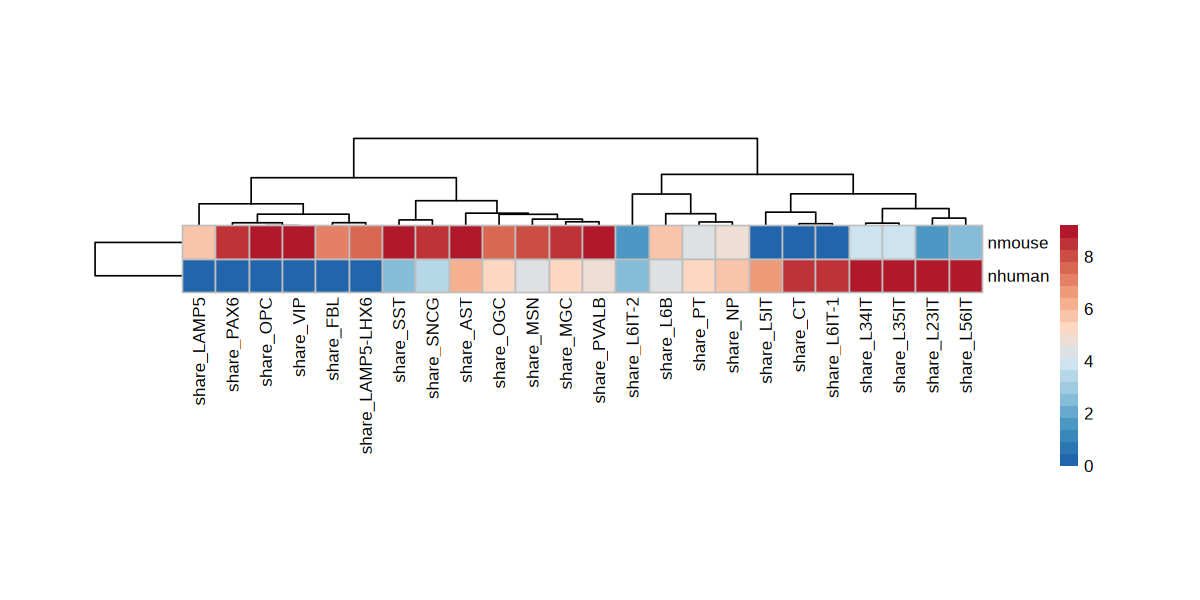

In [184]:
qmtx <- tresult %>% 
filter(!(hcelltype %in% badsharetype)) %>%
group_by(hcelltype, mcelltype) %>%
filter(p_val_adj < 0.05, abs(avg_diff) >= 0.1) %>%
summarise(total = n(),
          nmouse = sum(avg_diff < 0),
          nhuman = sum(avg_diff > 0)) %>%
ungroup %>% 
mutate(hcelltype = factor(hcelltype, levels = tcorder)) %>%
arrange(hcelltype) %>%
select(hcelltype, nmouse, nhuman) %>%
tibble::column_to_rownames("hcelltype")

options(repr.plot.width = 10, repr.plot.height = 5)
t1 <- log2(qmtx+1) %>% t %>% 
pheatmap(cluster_rows = T, cluster_cols = T, scale = "none", angle_col = 90, 
         cellheight = 20, cellwidth = 20,
         border_color = "grey", show_rownames = T,
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdBu"))(20)))  #c("white", "#59b4a2")

In [185]:
ggsave(t1, filename = "../Figure/FIG_human_mouse_integration_chromvar_diff_matched_sharesubclass.clean.coremotif.pdf", 
       dpi = 300, height = 5, width = 10)

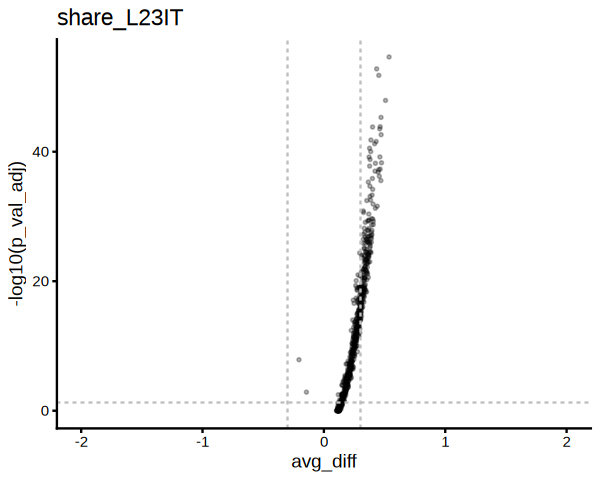

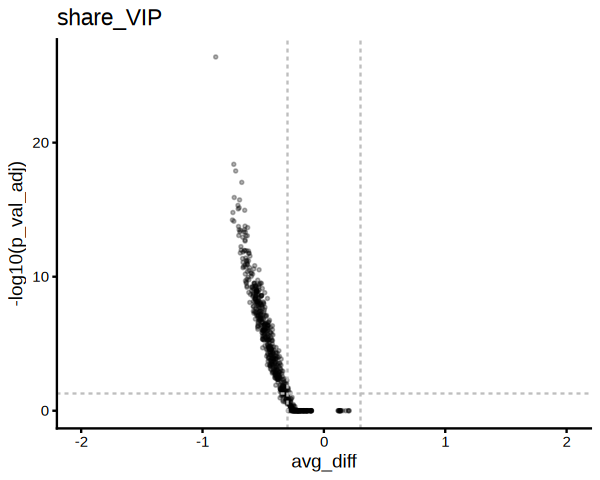

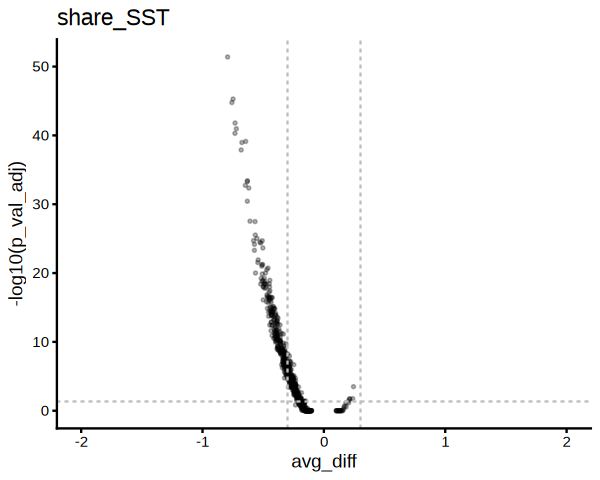

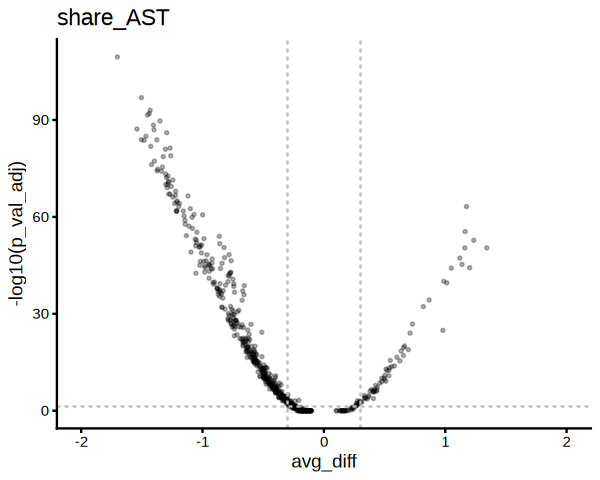

In [186]:
options(repr.plot.width = 5, repr.plot.height = 4)
f1 <- "share_L23IT"
tresult %>% filter(hcelltype == f1) %>%
ggplot(aes(x = avg_diff, y = -log10(p_val_adj))) + 
geom_point(alpha = 0.3, size = 0.5) + 
geom_hline(yintercept = -log10(0.05), linetype = 2, color = "grey") + 
geom_vline(xintercept = c(-0.3, 0.3), linetype = 2, color = "grey") + 
ggtitle(f1) + xlim(-2, 2) + 
theme_classic()

f1 <- "share_VIP"
tresult %>% filter(hcelltype == f1) %>%
ggplot(aes(x = avg_diff, y = -log10(p_val_adj))) + 
geom_point(alpha = 0.3, size = 0.5) + 
geom_hline(yintercept = -log10(0.05), linetype = 2, color = "grey") + 
geom_vline(xintercept = c(-0.3, 0.3), linetype = 2, color = "grey") + 
ggtitle(f1) + xlim(-2, 2) + 
theme_classic()

f1 <- "share_SST"
tresult %>% filter(hcelltype == f1) %>%
ggplot(aes(x = avg_diff, y = -log10(p_val_adj))) + 
geom_point(alpha = 0.3, size = 0.5) + 
geom_hline(yintercept = -log10(0.05), linetype = 2, color = "grey") + 
geom_vline(xintercept = c(-0.3, 0.3), linetype = 2, color = "grey") + 
ggtitle(f1) + xlim(-2, 2) + 
theme_classic()

f1 <- "share_AST"
tresult %>% filter(hcelltype == f1) %>%
ggplot(aes(x = avg_diff, y = -log10(p_val_adj))) + 
geom_point(alpha = 0.3, size = 0.5) + 
geom_hline(yintercept = -log10(0.05), linetype = 2, color = "grey") + 
geom_vline(xintercept = c(-0.3, 0.3), linetype = 2, color = "grey") + 
ggtitle(f1) + xlim(-2, 2) + 
theme_classic()

Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from UMAP to UMAP_”
Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from UMAP to UMAP_”


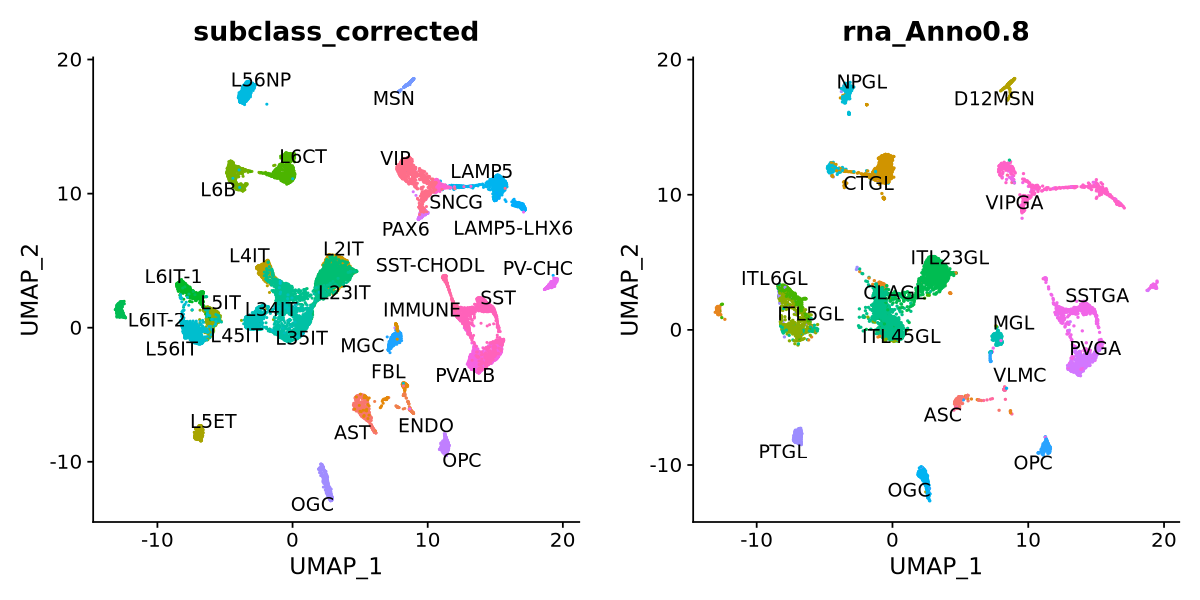

In [232]:
qcell <- intersect(colnames(hvarseurat), obj$dna_bc)
shvar <- subset(hvarseurat, cells = qcell)

mtx <- obj@reductions$umap@cell.embeddings
rownames(mtx) <- obj$dna_bc
mtx <- mtx[qcell,]
shvar[["umap"]] <- CreateDimReducObject(embeddings = mtx, key = "UMAP")

qcell <- intersect(colnames(mvarseurat), obj$dna_bc)
mhvar <- subset(mvarseurat, cells = qcell)

mtx <- obj@reductions$umap@cell.embeddings
rownames(mtx) <- obj$dna_bc
mtx <- mtx[qcell,]
mhvar[["umap"]] <- CreateDimReducObject(embeddings = mtx, key = "UMAP")

t1 <- DimPlot(shvar, group.by = "subclass_corrected", label = T, repel = T) + NoLegend()
t2 <- DimPlot(mhvar, group.by = "rna_Anno0.8", label = T, repel = T) + NoLegend()

options(repr.plot.width = 10, repr.plot.height = 5)
cowplot::plot_grid(t1, t2)

In [12]:
obj_mtx_collapse <- read.csv("human_mouse_chromvar_agg_deviation.csv", row.names = 1, check.names = F)
head(obj_mtx_collapse, 2)

,human:share_AST,human:share_OPC,human:share_MSN,human:share_ENDO,human:share_FBL,human:share_L23IT,human:share_L6IT-1,human:share_L4IT_vis,human:share_L34IT,human:share_PT,⋯,mouse:share_L34IT,mouse:share_PAX6,mouse:share_LAMP5-LHX6,mouse:share_L6IT-2,mouse:share_SST-CHODL,mouse:share_PV-CHC,mouse:share_FBL,mouse:share_L45IT,mouse:share_L4IT_vis,mouse:share_ENDO
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Arnt,-0.2675980,-0.2860119,0.2978928,-0.3977574,-0.2693924,-0.04564122,-0.06979305,-0.1351819,-0.09649084,-0.1196709,⋯,-0.3318334,0.3275826,0.5219681,0.192825978,0.5744754,0.1465179,0.2365683,-0.3608415,0.25613892,-0.04397673
Ahr::Arnt,-0.6686608,-0.1282176,0.4744329,-0.2939517,-0.2832344,0.26954135,0.17677587,-0.1356111,0.03253272,0.1940591,⋯,-0.4029514,0.4621172,0.5227709,0.004227994,0.8710691,0.5165789,0.4148280,0.2083998,0.01861789,0.10189980


In [843]:
head(obj_mtx_collapse)
unique(obj$snlabel)

,human:share_AST,human:share_OPC,human:share_MSN,human:share_ENDO,human:share_FBL,human:share_L23IT,human:share_L6IT-1,human:share_L4IT_vis,human:share_L34IT,human:share_PT,⋯,mouse:share_L34IT,mouse:share_PAX6,mouse:share_LAMP5-LHX6,mouse:share_L6IT-2,mouse:share_SST-CHODL,mouse:share_PV-CHC,mouse:share_FBL,mouse:share_L45IT,mouse:share_L4IT_vis,mouse:share_ENDO
Arnt,-0.2675980,-0.28601190,0.2978928,-0.39775741,-0.26939245,-0.04564122,-0.06979305,-0.13518189,-0.096490840,-0.11967091,⋯,-0.3318334,0.3275826,0.5219681,0.192825978,0.5744754,0.14651788,0.2365683,-0.3608414578,0.25613892,-0.04397673
Ahr::Arnt,-0.6686608,-0.12821755,0.4744329,-0.29395168,-0.28323440,0.26954135,0.17677587,-0.13561106,0.032532724,0.19405907,⋯,-0.4029514,0.4621172,0.5227709,0.004227994,0.8710691,0.51657888,0.4148280,0.2083998394,0.01861789,0.10189980
Mecom,-0.2261879,-0.20281992,0.1102250,0.07934893,0.00592754,0.06381407,0.07823820,-0.02216665,0.036007382,0.14639395,⋯,-0.2539205,0.4150976,0.4179682,-0.234407444,0.6156979,0.07404281,0.4628954,-0.1922540031,-0.14470563,0.23699761
Hand1::Tcf3,-0.3148279,-0.15856686,-0.4443747,-0.14006689,-0.08217269,-0.07189287,0.02587925,0.04618377,-0.018640096,-0.03571954,⋯,-0.2812824,0.6039327,0.5732487,-0.114921616,0.9742611,0.39472742,0.4321432,0.0007226233,0.62390043,0.39435621
Spz1,-0.1830411,0.02277858,0.1242978,0.19991633,-0.02937103,-0.05296358,0.06789845,-0.01600432,0.004551078,-0.05421959,⋯,-0.3449405,0.5216619,0.1443608,-0.204947711,0.9537553,0.24033696,0.6696269,-0.2982170811,-0.03846290,0.28488039
Nobox,0.3320533,0.07088499,0.1887236,0.04322613,0.24027215,-0.04221133,-0.09355385,-0.10860780,-0.060193428,-0.09371700,⋯,-0.4092824,0.7130650,0.3867000,-0.432670248,0.6752840,0.26769723,0.1971116,-0.2002825872,-0.26490502,0.20007893


[1] "share_L6IT-2"     "share_SST"        "share_CT"         "share_L6IT-1"    
 [5] "share_L5IT"       "share_L23IT"      "share_LAMP5"      "share_PVALB"     
 [9] "share_L56IT"      "share_L6B"        "share_LAMP5-LHX6" "share_PT"        
[13] "share_VIP"        "share_L45IT"      "share_L35IT"      "share_PV-CHC"    
[17] "share_SNCG"       "share_PAX6"       "share_SST-CHODL"  "share_NP"        
[21] "share_AST"        "share_MGC"        "share_OGC"        "share_L34IT"     
[25] "share_ENDO"       "share_OPC"        "share_FBL"        "share_MSN"       
[29] "share_L4IT_vis"

## Correlation analysis for defining conserved TFs (not core motifs)

In [641]:
mcor <- list()
corder <- setdiff(tcorder, badsharetype)
for (motif in rownames(obj_mtx_collapse)){
    l1 <- obj_mtx_collapse[motif, paste0("human:", corder)]
    l2 <- obj_mtx_collapse[motif, paste0("mouse:", corder)]
    if(!is.na(sum(l1))){
        ### calculate cor
        test <- cor.test(l1, l2, method = "spearman", use = "complete")
        mcor[[motif]] <- data.frame(motif = motif, pvalue = test$p.value, rho = as.numeric(test$estimate))
    }
}

mcor <- do.call(rbind, mcor)

In [642]:
### also generate one for background:
set.seed(921)
obj_mtx <- chromvar[["RNA"]]@data
group.by = "nlabel"
meta = chromvar@meta.data

# meta[,group.by] <- sample(meta[,group.by], size = nrow(meta), replace = F)
rownames(obj_mtx) <- sample(rownames(obj_mtx), size = nrow(obj_mtx), replace = F)
colnames(obj_mtx) <- sample(colnames(obj_mtx), size = ncol(obj_mtx), replace = F)

colnames(obj_mtx) <- meta[colnames(obj_mtx), group.by]
obj_mtx <- as(obj_mtx, "TsparseMatrix")
obj_mtx_collapse2 <- OP2(obj_mtx)
obj_mtx_collapse2 <- as(obj_mtx_collapse2, "matrix")

ccount <- table(meta[, group.by]) %>% as.data.frame %>% tibble::column_to_rownames("Var1")
obj_mtx_collapse2 <- t(t(obj_mtx_collapse2)/(ccount[colnames(obj_mtx_collapse2),]))

mcor2 <- list()
for (motif in rownames(obj_mtx_collapse)){
    l1 <- obj_mtx_collapse2[motif, paste0("human:", corder)]
    l2 <- obj_mtx_collapse2[motif, paste0("mouse:", corder)]
    if(!is.na(sum(l1))){
        ### calculate cor
        test <- cor.test(l1, l2, method = "spearman", use = "complete")
        mcor2[[motif]] <- data.frame(motif = motif, pvalue = test$p.value, rho = as.numeric(test$estimate))
    }
}

mcor2 <- do.call(rbind, mcor2)

In [644]:
library(qvalue)

x_fg <- mcor$rho
x_bg <- mcor2$rho

p_emp <- empPvals(stat = x_fg, stat0 = x_bg)
q_emp <- qvalue(p_emp)$qvalues
sig_fg <- x_fg[q_emp < 0.05]
cutoff <- min(sig_fg)
cutoff

[1] 0.2737095

Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”
Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”
Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”
Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”
Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”


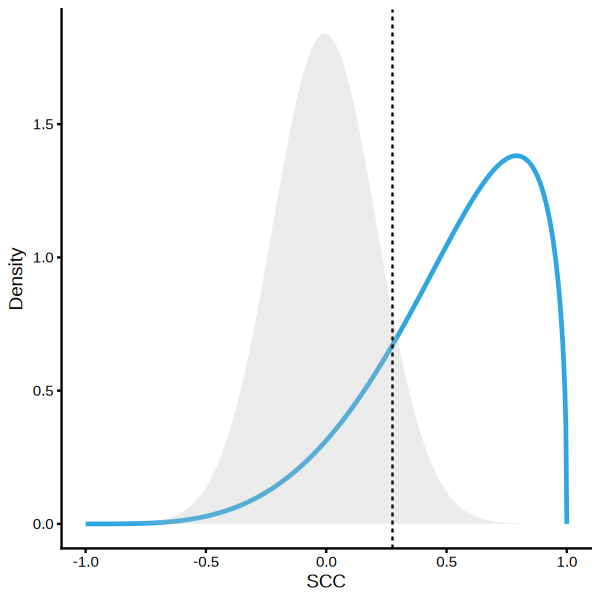

In [645]:
x <- (mcor$rho + 1) / 2
fit <- MASS::fitdistr(x, dbeta,
                      start = list(shape1 = 2, shape2 = 2))

shape1 <- fit$estimate[1]
shape2 <- fit$estimate[2]

# generate smooth curve
xgrid <- seq(0, 1, length.out = 500)
ygrid <- dbeta(xgrid, shape1, shape2)

# back-transform xgrid to [-1,1]
plot_df <- data.frame(rho = xgrid * 2 - 1,density = ygrid / 2) # divide by 2 for rescale

t1 <- ggplot(mcor, aes(x = rho)) +
geom_line(data = plot_df, aes(x = rho, y = density),
        color = "#2EA7E0", linewidth = 1) +
stat_function(data = mcor2, aes(x = rho, group = 1), fun = dnorm, geom = 'area',
          args = list(mean = mean(mcor2$rho), sd = sd(mcor2$rho)),
          size = 1, fill = "grey", alpha = 0.3) + 
geom_vline(xintercept = cutoff, linetype = 2) +
theme_classic() + xlab("SCC") + ylab("Density") + xlim(c(-1,1))

options(repr.plot.width = 5, repr.plot.height = 5)
t1

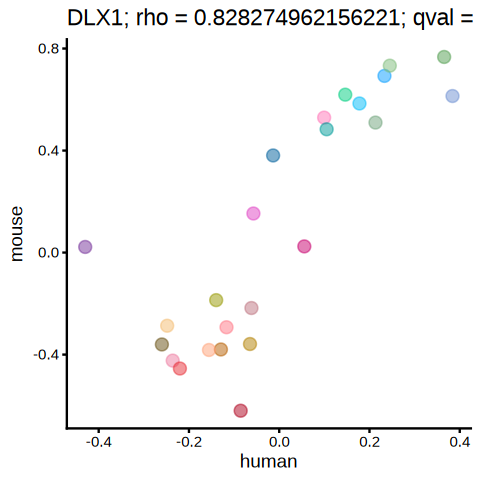

In [647]:
### show a illustration
motif = "DLX1"
qrho <- mcor[motif, "rho"]
qval <- mcor[motif, "emp_q"]

t1 <- data.frame(human = obj_mtx_collapse[motif, paste0("human:", corder)],
mouse = obj_mtx_collapse[motif, paste0("mouse:", corder)], celltype = corder) %>%
ggplot(aes(x = human, y = mouse, label = celltype)) + 
geom_point(aes(color = celltype), alpha = 0.5, size = 3) + 
# ggrepel::geom_text_repel() + 
theme_classic() + ggtitle(paste0(motif, "; rho = ", qrho, "; qval = ", qval)) + 
scale_color_manual(values = ccol5) + 
NoLegend()

options(repr.plot.width = 4, repr.plot.height = 4)
t1

### Plot significant motif summary

In [42]:
qmotif <- mcor %>% filter(emp_q < 0.05) %>% rownames
qmotif <- intersect(qmotif, rownames(obj_mtx_collapse))
qmotif2 <- aresult %>% 
filter(gene %in% qmotif, p_val_adj < 0.05, abs(avg_diff) >= 0.5, cluster %in% corder) %>% 
group_by(cluster) %>% slice_min(p_val_adj, n = 1) %>% 
slice_sample(n = 1) %>% ungroup %>%
select(gene) %>% unlist %>% as.character %>% unique

length(qmotif)
length(qmotif2)

[1] 586

[1] 16

In [44]:
smat1 <- obj_mtx_collapse[qmotif, paste0("human:", corder)]
smat2 <- obj_mtx_collapse[qmotif, paste0("mouse:", corder)]

max_indices <- max.col(smat1)
permutation_vector <- order(max_indices)
smat1 <- smat1[permutation_vector, ]

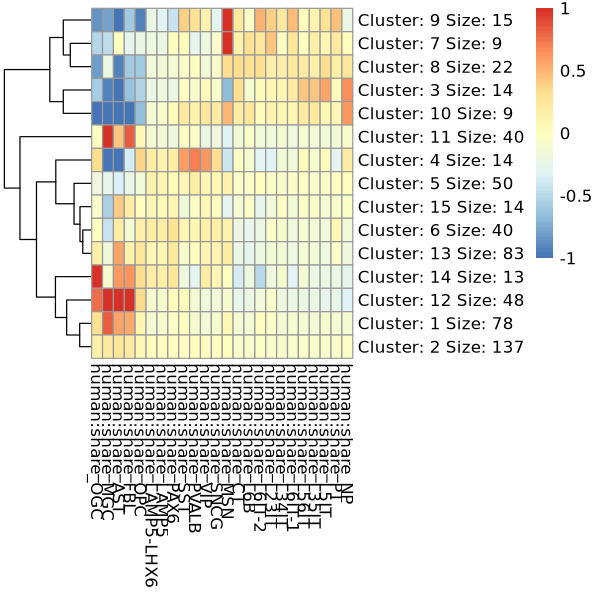

In [46]:
kn <- 15
set.seed(921)

options(repr.plot.width = 5, repr.plot.height = 5)
d1 <- smat1 %>% 
pheatmap(cluster_cols = F, cluster_rows = T, breaks = seq(-1, 1, 0.02),kmeans_k = kn)

qorder <- d1$kmeans$cluster %>% as.data.frame %>%
setNames("kmeansk") %>%
mutate(kmeansk = factor(kmeansk, levels = c(12,14,1,11,2,13,15,6,5,4,8,9,7,3,10))) %>%
arrange(kmeansk)

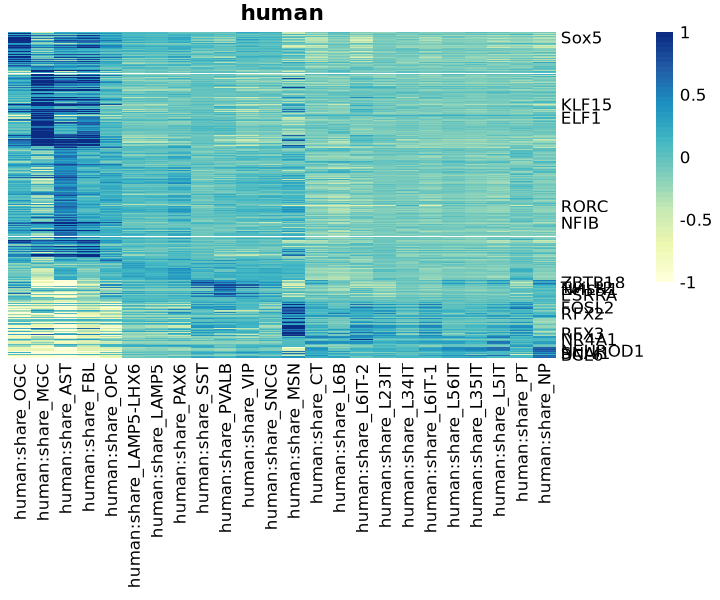

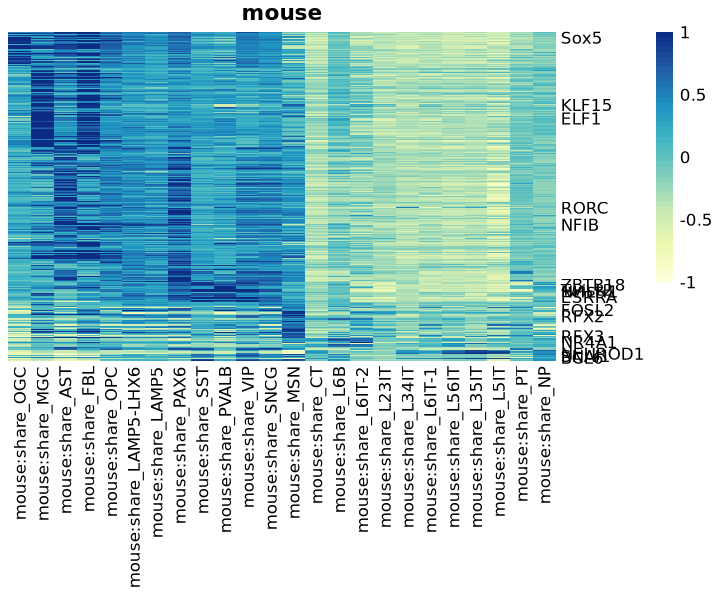

In [50]:
qlabel <- rownames(smat1)
qlabel[!(qlabel %in% qmotif2)] <- ""

options(repr.plot.width = 6, repr.plot.height = 5)
t1 <- smat1 %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 90,
         labels_row = qlabel, breaks = seq(-1, 1, 0.04), main = "human", 
         color = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(50)) 

t2 <- smat2[rownames(smat1), gsub("human", "mouse", colnames(smat1))] %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 90, 
         labels_row = qlabel, breaks = seq(-1, 1, 0.04), main = "mouse", 
         color = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(50)) 

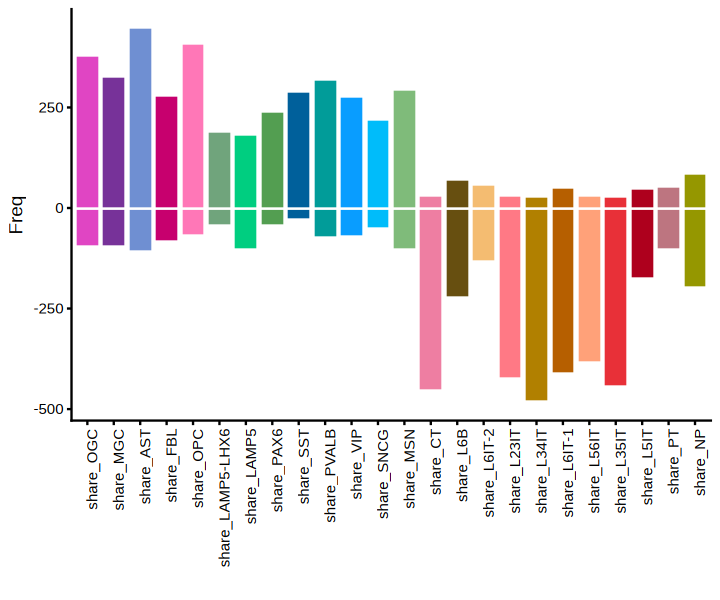

In [831]:
aresult %>% filter(p_val_adj < 0.05, gene %in% qmotif) %>%
mutate(direction = ifelse(avg_diff > 0, "pos", "neg")) %>%
select(cluster, direction) %>% table %>% as.data.frame %>%
filter(cluster %in% corder) %>%
mutate(cluster = factor(cluster, levels = corder)) %>%
mutate(Freq = ifelse(direction == "pos", Freq, -1*Freq)) %>%
ggplot(aes(x = cluster, y = Freq, fill = cluster)) + 
geom_col(color = "white") + 
theme_classic() + 
theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1)) + 
xlab("") + scale_fill_manual(values = ccol5) + NoLegend()

## Calculate TF and motif cor

In [114]:
length(qmotif)
intersect(rbind(htf, mtf)$motif, qmotif) %>% length
setdiff(qmotif, rbind(htf, mtf)$motif)

[1] 586

[1] 586

character(0)

In [126]:
tfcor <- list()
corder <- setdiff(tcorder, badsharetype)
for (qqmotif in qmotif){
    l1 <- obj_mtx_collapse[qqmotif, paste0("human:", corder)]
    l2 <- obj_mtx_collapse[qqmotif, paste0("mouse:", corder)]
    tf <- rbind(htf, mtf) %>% filter(motif == qqmotif) %>% select(tf) %>% unlist %>% as.character
    if(!is.na(sum(l1))){
        for (i in 1:length(tf)){
            ### convert name: 
            qtf = tf[i]
            qtf <- ifelse(qtf %in% gene_df$input_gene, qtf, gene_df[gene_df$ortholog_gene == qtf, ]$input_gene)
            if (length(qtf) > 0 && !is.na(qtf) && (qtf %in% rownames(rpkm))){
                g1 <- rpkm[qtf, paste0("human:", corder)] %>% unlist
                g2 <- rpkm[qtf, paste0("mouse:", corder)] %>% unlist
                test1 <- cor.test(l1, g1, method = "pearson")
                test2 <- cor.test(l2, g2, method = "pearson")
                tfcor[[paste0(qqmotif, "__", qtf)]] <- data.frame(motif = qqmotif, tf = qtf,
                                                                  human_p = as.numeric(test1$p.value),
                                                                  human_rho = as.numeric(test1$estimate), 
                                                                  mouse_p = as.numeric(test2$p.value),
                                                                  mouse_rho = as.numeric(test2$estimate))   
            }
        }
    }
}

tfcor <- do.call(rbind, tfcor)
tfcor$human_p[is.na(tfcor$human_p)] <- 1
tfcor$mouse_p[is.na(tfcor$mouse_p)] <- 1
tfcor$human_rho[is.na(tfcor$human_rho)] <- 0
tfcor$mouse_rho[is.na(tfcor$mouse_rho)] <- 0
tfcor$human_q <- p.adjust(tfcor$human_p, method = "BH")
tfcor$mouse_q <- p.adjust(tfcor$mouse_p, method = "BH")

Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation i

Warning message:
“ggrepel: 17 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


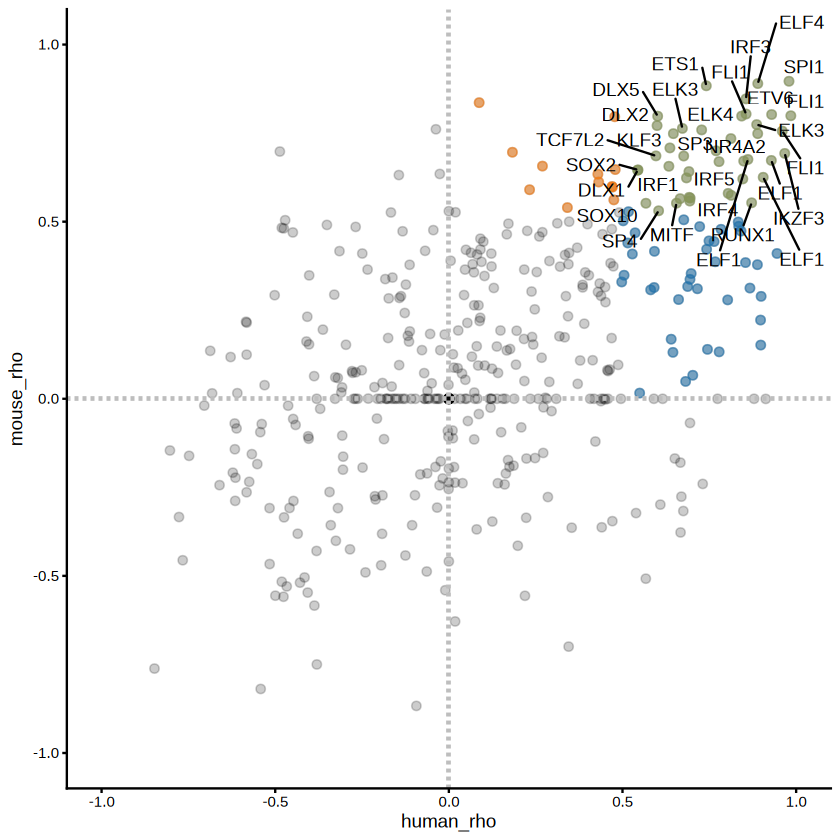

In [673]:
tmp1 <- tfcor %>% filter(mouse_q < 0.05, human_rho > 0, mouse_rho > 0, human_q >= 0.05)
tmp2 <- tfcor %>% filter(mouse_q >= 0.05, human_rho > 0, mouse_rho > 0, human_q < 0.05)
tmp3 <- tfcor %>% filter(mouse_q < 0.05, human_rho > 0, mouse_rho > 0, human_q < 0.05)
t1 <- tfcor %>%
ggplot(aes(x = human_rho, y = mouse_rho)) +
geom_point(alpha = 0.2, size = 2) + 
geom_point(data = tmp1, aes(x = human_rho, y = mouse_rho), color = "#ff7f0e", alpha = 0.5, size = 2) + 
geom_point(data = tmp2, aes(x = human_rho, y = mouse_rho), color = "#1f77b4", alpha = 0.5, size = 2) + 
geom_point(data = tmp3, aes(x = human_rho, y = mouse_rho), color = "#8A9A5B", alpha = 0.5, size = 2) + 
ggrepel::geom_text_repel(data = tmp3, aes(x = human_rho, y = mouse_rho, label = tf), max.overlaps = 15) + 
geom_hline(yintercept = 0, linetype = 2, color = "grey", size = 1) +
geom_vline(xintercept = 0, linetype = 2, color = "grey", size = 1) +
theme_classic() + xlim(-1, 1) + ylim(-1, 1)

options(repr.plot.width = 7, repr.plot.height = 7)
t1
### DLX5, NFIB, DLX1 

### Run similar analysis for H3K27me3

In [1120]:
### H3K27me3: no scale is needed
rchromvar2 <- CreateAssayObject(data = cbind(hvarseurat2[["RNA"]]@data[validm,], mvarseurat2[["RNA"]]@data[validm,]))
rchromvar2 <- CreateSeuratObject(rchromvar2, meta.data = bind_rows(hvarseurat2@meta.data, mvarseurat2@meta.data))

hmat2 <- scale_by_motif(hvarseurat2[["RNA"]]@data)
mmat2 <- scale_by_motif(mvarseurat2[["RNA"]]@data)
chromvar2 <- CreateAssayObject(data = cbind(hmat2[validm,], mmat2[validm,]))
chromvar2 <- CreateSeuratObject(chromvar2, meta.data = bind_rows(hvarseurat2@meta.data, mvarseurat2@meta.data))

rchromvar2 <- subset(rchromvar2, cells = intersect(colnames(rchromvar2), obj$dna_bc))
rchromvar2$slabel <- obj@meta.data[match(colnames(rchromvar2), obj$dna_bc),]$snlabel
rchromvar2$species <- NA
rchromvar2@meta.data[intersect(colnames(hvarseurat2), colnames(rchromvar2)), ]$species <- "human"
rchromvar2@meta.data[intersect(colnames(hvarseurat2), colnames(rchromvar2)), ]$species <- "mouse"


chromvar2 <- subset(chromvar2, cells = intersect(colnames(chromvar2), obj$dna_bc))
chromvar2$slabel <- obj@meta.data[match(colnames(chromvar2), obj$dna_bc),]$snlabel
chromvar2$species <- NA
chromvar2@meta.data[intersect(colnames(hvarseurat2), colnames(rchromvar2)), ]$species <- "human"
chromvar2@meta.data[intersect(colnames(mvarseurat2), colnames(rchromvar2)), ]$species <- "mouse"

Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”
Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


In [261]:
Idents(chromvar2) <- "slabel"
aresult <- FindAllMarkers(chromvar2, only.pos = F, mean.fxn = rowMeans, fc.name = "avg_diff", min.pct = 0.05)
write.csv(aresult, "human_mouse_chromvar_diff_all_subclass.nospecies.H3K27me3.clean.coremotif.csv", quote = F, row.names = F, col.names = T)

Calculating cluster share_AST

Warning message:
“`PackageCheck()` was deprecated in SeuratObject 5.0.0.
ℹ Please use `rlang::check_installed()` instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster share_OPC

Calculating cluster share_MSN

Calculating cluster share_ENDO

Calculating cluster share_FBL

Calculating cluster share_MGC

Calculating cluster share_L23IT

Calculating cluster share_L6IT-1

Calculatin

## Calculate aggregtaed signal and cor vs background

In [1124]:
chromvar2$nlabel <- paste0(chromvar2$species, ":", chromvar2$slabel)
obj_mtx <- chromvar2[["RNA"]]@data
group.by = "nlabel"
meta = chromvar2@meta.data

colnames(obj_mtx) <- meta[colnames(obj_mtx), group.by]
obj_mtx <- as(obj_mtx, "TsparseMatrix")
obj_mtx_collapse <- OP2(obj_mtx)
spars <- length(obj_mtx_collapse@x)/obj_mtx_collapse@Dim[1]/obj_mtx_collapse@Dim[2]
cat(paste0("sparsity: ", spars, "\n"))
obj_mtx_collapse <- as(obj_mtx_collapse, "matrix")

ccount <- table(meta[, group.by]) %>% as.data.frame %>% tibble::column_to_rownames("Var1")
obj_mtx_collapse <- t(t(obj_mtx_collapse)/(ccount[colnames(obj_mtx_collapse),]))

sparsity: 1


In [68]:
# write.csv(obj_mtx_collapse, "human_mouse_chromvar_agg_deviation.H3K27me3.csv", quote = F, row.names = T, col.names = T)
obj_mtx_collapse <- read.csv("human_mouse_chromvar_agg_deviation.H3K27me3.csv", header = T, row.names = 1, check.names = F)

In [316]:
mcor <- list()
corder <- setdiff(tcorder, badsharetype)
for (motif in rownames(obj_mtx_collapse)){
    l1 <- obj_mtx_collapse[motif, paste0("human:", corder)] %>% unlist %>% as.numeric
    l2 <- obj_mtx_collapse[motif, paste0("mouse:", corder)] %>% unlist %>% as.numeric
    if(!is.na(sum(l1))){
        ### calculate cor
        test <- cor.test(l1, l2, method = "spearman", use = "complete")
        mcor[[motif]] <- data.frame(motif = motif, pvalue = test$p.value, rho = as.numeric(test$estimate))
    }
}

mcor <- do.call(rbind, mcor)

In [305]:
### also generate one for background:
set.seed(921)
obj_mtx <- chromvar2[["RNA"]]@data
group.by = "nlabel"
meta = chromvar2@meta.data

rownames(obj_mtx) <- sample(rownames(obj_mtx), size = nrow(obj_mtx), replace = F)
colnames(obj_mtx) <- sample(colnames(obj_mtx), size = ncol(obj_mtx), replace = F)

colnames(obj_mtx) <- meta[colnames(obj_mtx), group.by]
obj_mtx <- as(obj_mtx, "TsparseMatrix")
obj_mtx_collapse2 <- OP2(obj_mtx)
obj_mtx_collapse2 <- as(obj_mtx_collapse2, "matrix")

ccount <- table(meta[, group.by]) %>% as.data.frame %>% tibble::column_to_rownames("Var1")
obj_mtx_collapse2 <- t(t(obj_mtx_collapse2)/(ccount[colnames(obj_mtx_collapse2),]))

mcor2 <- list()
for (motif in rownames(obj_mtx_collapse)){
    l1 <- obj_mtx_collapse2[motif, paste0("human:", corder)] %>% unlist %>% as.numeric
    l2 <- obj_mtx_collapse2[motif, paste0("mouse:", corder)] %>% unlist %>% as.numeric
    if(!is.na(sum(l1))){
        ### calculate cor
        test <- cor.test(l1, l2, method = "spearman", use = "complete")
        mcor2[[motif]] <- data.frame(motif = motif, pvalue = test$p.value, rho = as.numeric(test$estimate))
    }
}

mcor2 <- do.call(rbind, mcor2)

In [321]:
library(qvalue)

x_fg <- mcor$rho
x_bg <- mcor2$rho

p_emp <- empPvals(stat = x_fg, stat0 = x_bg)

### Also get negative cutoff?
x_fg <- -mcor$rho
x_bg <- -mcor2$rho

p_emp2 <- empPvals(stat = x_fg, stat0 = x_bg)

t_emp <- qvalue(c(p_emp, p_emp2))$qvalues
q_emp <- t_emp[1:length(p_emp)]
q_emp2 <- t_emp[(1+length(p_emp)):length(t_emp)]
sig_fg <- mcor$rho[q_emp < 0.05]
cutoff <- min(sig_fg)

sig_fg <- -mcor$rho[q_emp2 < 0.05]
cutoff2 <- -min(sig_fg)

cutoff
cutoff2

[1] 0.54

[1] -0.4817391

Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”
Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”


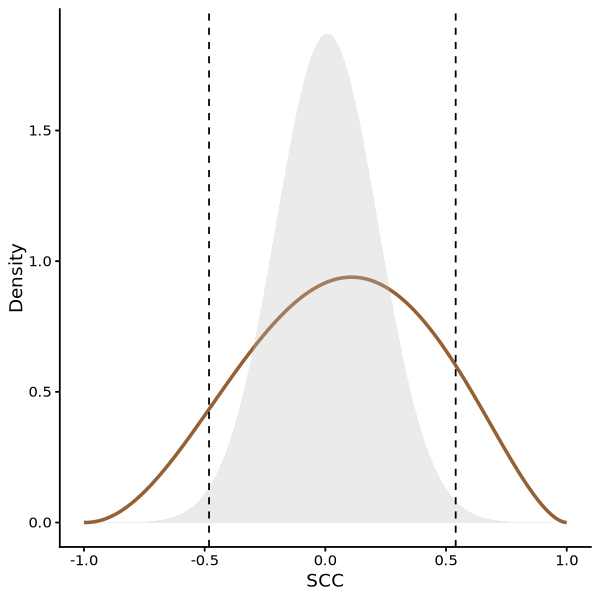

In [323]:
x <- (mcor$rho + 1) / 2
fit <- MASS::fitdistr(x, dbeta,
                      start = list(shape1 = 2, shape2 = 2))

shape1 <- fit$estimate[1]
shape2 <- fit$estimate[2]

# generate smooth curve
xgrid <- seq(0, 1, length.out = 500)
ygrid <- dbeta(xgrid, shape1, shape2)

# back-transform xgrid to [-1,1]
plot_df <- data.frame(rho = xgrid * 2 - 1,density = ygrid / 2) # divide by 2 for rescale

t1 <- ggplot(mcor, aes(x = rho)) +
geom_line(data = plot_df, aes(x = rho, y = density),
        color = "#956134", linewidth = 1) +
stat_function(data = mcor2, aes(x = rho, group = 1), fun = dnorm, geom = 'area',
          args = list(mean = mean(mcor2$rho), sd = sd(mcor2$rho)),
          size = 1, fill = "grey", alpha = 0.3) + 
geom_vline(xintercept = cutoff, linetype = 2) +
geom_vline(xintercept = cutoff2, linetype = 2) +
theme_classic() + xlab("SCC") + ylab("Density") + xlim(c(-1,1))

options(repr.plot.width = 5, repr.plot.height = 5)
t1

In [326]:
mcor %>% filter(emp_q_pos < 0.05) %>% nrow
mcor %>% filter(emp_q_neg < 0.05) %>% nrow

[1] 104

[1] 58

### Summary of repressive motifs?

In [71]:
### Positive first
qmotif <- mcor %>% filter(emp_q_pos < 0.05) %>% rownames
qmotif <- intersect(qmotif, rownames(obj_mtx_collapse))

smat1 <- obj_mtx_collapse[qmotif, paste0("human:", corder)]
smat2 <- obj_mtx_collapse[qmotif, paste0("mouse:", corder)]

max_indices <- max.col(smat1)
permutation_vector <- order(max_indices)
smat1 <- smat1[permutation_vector, ]

In [72]:
qmotif2 <- aresult %>% 
filter(gene %in% qmotif, p_val_adj < 0.05, abs(avg_diff) >= 0.5, cluster %in% corder) %>%
group_by(cluster) %>% slice_min(p_val_adj, n = 1) %>% 
slice_sample(n = 1) %>% ungroup %>%
select(gene) %>% unlist %>% as.character %>% unique

length(qmotif)
length(qmotif2)

[1] 104

[1] 4

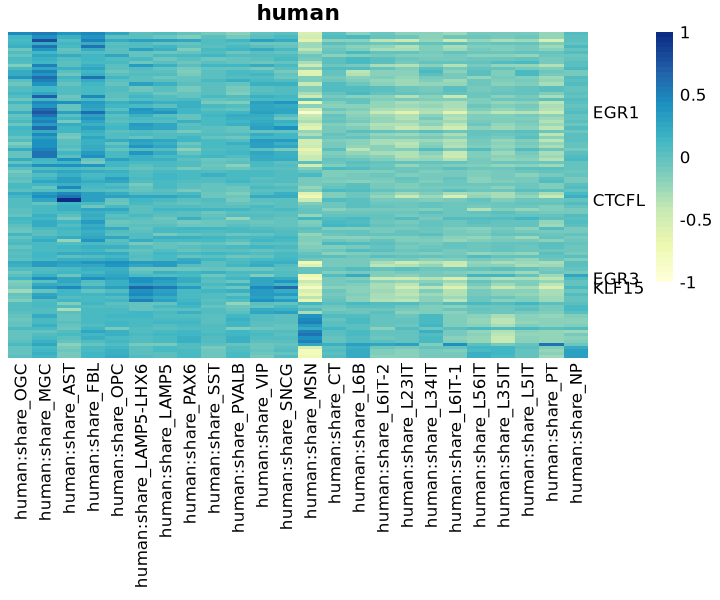

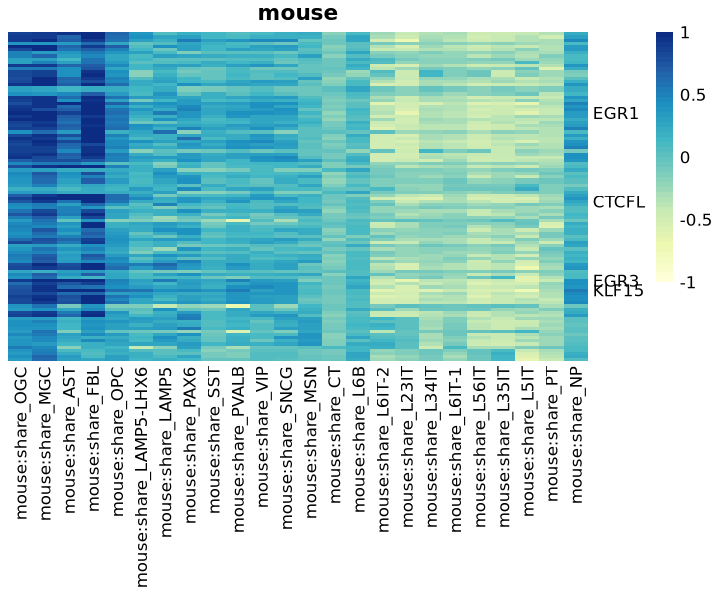

In [371]:
qlabel <- rownames(smat1)
qlabel[!(qlabel %in% qmotif2)] <- ""

options(repr.plot.width = 6, repr.plot.height = 5)
t1 <- smat1 %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 90, border_color = NA,
         labels_row = qlabel, breaks = seq(-1, 1, 0.04), main = "human", 
         color = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(50)) 

# t2 <- smat2[t1$tree_row$labels[t1$tree_row$order], gsub("human", "mouse", colnames(smat1))] %>% 
t2 <- smat2[rownames(smat1), gsub("human", "mouse", colnames(smat1))] %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 90, border_color = NA,
         labels_row = qlabel, breaks = seq(-1, 1, 0.04), main = "mouse", 
         color = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(50)) 

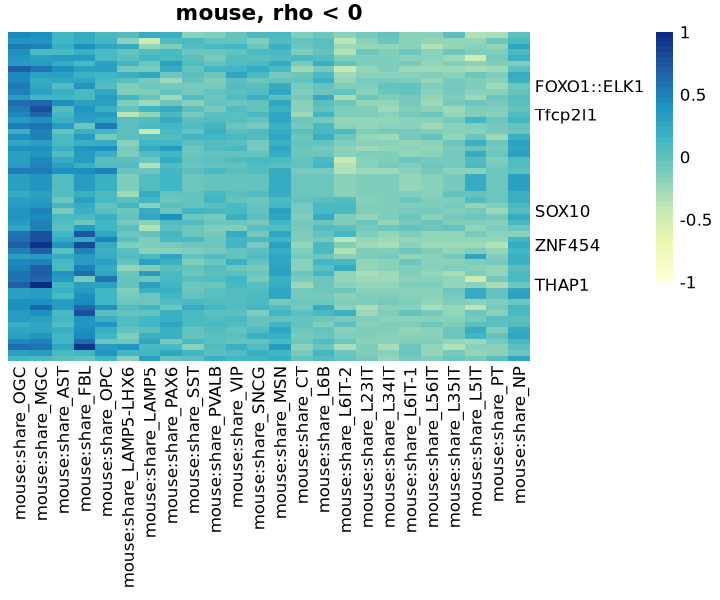

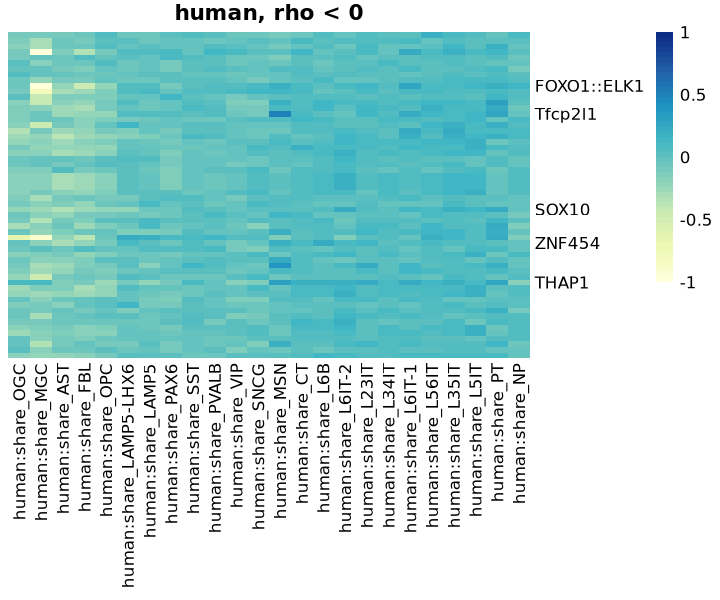

In [353]:
### Negative?
qmotif <- mcor %>% filter(emp_q_neg < 0.05) %>% rownames
qmotif <- intersect(qmotif, rownames(obj_mtx_collapse))
qmotif2 <- aresult %>% 
filter(gene %in% qmotif, p_val_adj < 0.05, abs(avg_diff) >= 0.3, cluster %in% corder) %>%
group_by(cluster) %>% slice_min(p_val_adj, n = 1) %>% 
slice_sample(n = 1) %>% ungroup %>%
select(gene) %>% unlist %>% as.character %>% unique

smat1 <- obj_mtx_collapse[qmotif, paste0("human:", corder)]
smat2 <- obj_mtx_collapse[qmotif, paste0("mouse:", corder)]

### order through mouse
max_indices <- max.col(smat2)
permutation_vector <- order(max_indices)
smat2 <- smat2[permutation_vector, ]

qlabel <- rownames(smat2)
qlabel[!(qlabel %in% qmotif2)] <- ""

options(repr.plot.width = 6, repr.plot.height = 5)
t3 <- smat2 %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 90, border_color = NA,
         labels_row = qlabel, 
         breaks = seq(-1, 1, 0.04), 
         main = "mouse, rho < 0", 
         color = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(50)) 

t4 <- smat1[rownames(smat2), gsub("mouse", "human", colnames(smat2))] %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 90, border_color = NA,
         labels_row = qlabel, 
         breaks = seq(-1, 1, 0.04), 
         main = "human, rho < 0", 
         color = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(50)) 

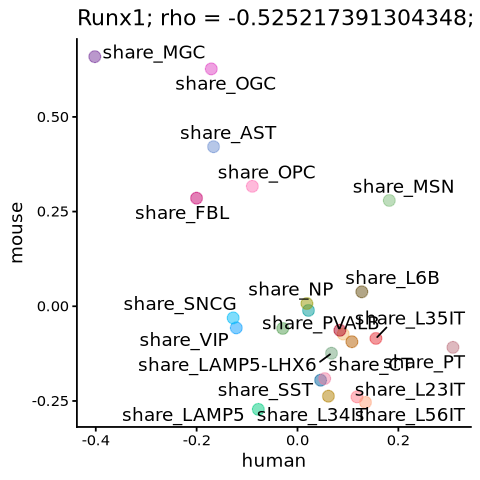

In [366]:
### show a illustration
motif = "Runx1"
qrho <- mcor[motif, "rho"]
qval <- mcor[motif, "emp_q_neg"]

t1 <- data.frame(human = unlist(obj_mtx_collapse[motif, paste0("human:", corder)]),
mouse = unlist(obj_mtx_collapse[motif, paste0("mouse:", corder)]), celltype = corder) %>%
ggplot(aes(x = human, y = mouse, label = celltype)) + 
geom_point(aes(color = celltype), alpha = 0.5, size = 3) + 
ggrepel::geom_text_repel() + 
theme_classic() + ggtitle(paste0(motif, "; rho = ", qrho, "; qval = ", qval)) + 
scale_color_manual(values = ccol5) + 
NoLegend()

options(repr.plot.width = 4, repr.plot.height = 4)
t1

ggsave(t1, filename = paste0("../Figure/FIG_human_mouse_integration_chromvar_cor_example_H3K27me3_", motif, ".pdf"), 
       dpi = 300, height = 4, width = 4)